In [18]:
# in case you are working on modelgym itself you might want install it from local directory
# to do so just uncomment the following line
#!pip install -e /notebooks/

In [5]:
import os
import pickle
import itertools
import pandas as pd
import numpy as np
#from modelgym import model
import functools
import modelgym
from modelgym.util import TASK_CLASSIFICATION
from modelgym.trainer import Trainer
from modelgym.tracker import ProgressTrackerFile, ProgressTrackerMongo
from sklearn.metrics import roc_auc_score
from hyperopt.mongoexp import MongoTrials
from modelgym.util import split_and_preprocess
from sklearn.model_selection import train_test_split
from collections import OrderedDict
print ("ModelGym version", modelgym.__version__)

ModelGym version 0.1.3


In [6]:
########### NROWS, N_ESTIMATORS, N_PROBES, TEST_SIZE, N_CV_SPLITS, OPTIMIZER
config_tuple = {
    'test': (1000, 10,  2, 0.5, 2, 'random'),
    'pror': (None, 1000, 100, 0.5, 2, 'random'), # production with random hyperopt suggestor
    'prot': (None, 1000, 100, 0.5, 2, 'tpe'),    # production with tpe hyperopt suggestor
    'demi': (10000, 100, 5, 0.5, 2, 'random')
}
CONFIG = 'test' if 'EXP_CONFIG' not in os.environ else os.environ['EXP_CONFIG']
NROWS, N_ESTIMATORS, N_PROBES, TEST_SIZE, N_CV_SPLITS, OPTIMIZER = config_tuple[CONFIG]
CANDIDATES = OrderedDict([
    ('XGBoost', modelgym.XGBModel), 
    ('LightGBM', modelgym.LGBModel),
])
RESULTS_DIR = "results"
LOAD_CACHE = False
if 'MONGO_PORT_27017_TCP_ADDR' in os.environ:
    mongo_host = os.environ['MONGO_PORT_27017_TCP_ADDR'] if 'MONGO_PORT_27017_TCP_ADDR' in os.environ else 'cern-mc01h'
    mongo_port = int(os.environ['MONGO_PORT_27017_TCP_PORT']) if 'MONGO_PORT_27017_TCP_PORT' in os.environ else 27017
    mongo_db = os.environ['MONGO_DB'] if 'MONGO_DB' in os.environ else 'trials'
    tracker_factory = functools.partial(ProgressTrackerMongo, mongo_host, mongo_port, mongo_db, config_key=CONFIG)
    print ("Using Mongo as backend for tracking")
else:
    tracker_factory = functools.partial(ProgressTrackerFile, RESULTS_DIR, config_key=CONFIG)
    print ("Using File as backend for tracking")

print ("Running experiment cofiguration:", CONFIG)

Using File as backend for tracking
Running experiment cofiguration: test


## Download & read data file

In [7]:
%%bash 
if [ ! -d data ] ; then 
    mkdir data 
    cd data
    curl https://cernbox.cern.ch/index.php/s/N1dpSAPgl30szYM/download | gunzip -c > XY2d.pickle
    cd ..
fi
ls -l data

total 133112
-rw-r--r-- 1 root root 136304022 Aug 11 22:41 XY2d.pickle


In [8]:
def read_data(fname, nrows=None, shuffle=True):
    with open(fname,'rb') as fh:
        X, y = pickle.load(fh,encoding='bytes')
    index = np.arange(X.shape[0])
    if nrows is None:
        nrows = X.shape[0]
    weights = np.ones(nrows) # uh, well...
    if shuffle:
        index_perm = np.random.permutation(index)
    else:
        index_perm = index
    return X[index_perm[:nrows]], y[index_perm[:nrows]], weights


X, y, weights = read_data("data/XY2d.pickle", nrows=NROWS)

In [9]:
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, weights, test_size=TEST_SIZE)

In [10]:
cv_pairs, (dtrain, dtest) = split_and_preprocess(X_train.copy(), y_train, 
                                                X_test.copy(), y_test, 
                                                cat_cols=[], n_splits=N_CV_SPLITS)

## Run them all

In [11]:
trackers = {}
def init_keys_dict():
    return dict([(k, None) for k in CANDIDATES.keys()])
default_cv_result = init_keys_dict()
tuned_cv_result = init_keys_dict()
default_test_result = init_keys_dict()
tuned_test_result = init_keys_dict()
trials = init_keys_dict()
trainer = Trainer(hyperopt_evals=N_PROBES, n_estimators=N_ESTIMATORS)

In [12]:
for model_id, model_class in CANDIDATES.items():
    model = model_class(TASK_CLASSIFICATION)
    print ("~"*20, model.get_name(), "~"*20)
    trackers[model_id] = tracker_factory(model_name=model.get_name())
    if LOAD_CACHE:
        default_cv_result[model_id], default_test_result[model_id], tuned_cv_result[model_id], tuned_test_result[model_id], trials[model_id] = \
            trackers[model_id].load_state(as_list=True)
    
    
    if default_cv_result[model_id] is None:
        default_cv_result[model_id] = trainer.crossval_fit_eval(model, cv_pairs)
        trackers[model_id].save_state(default_cv=default_cv_result[model_id])
    trainer.print_result(default_cv_result[model_id], 'Default {} result on CV'.format(model.get_name()))

    if default_test_result[model_id] is None:
        default_test_result[model_id] = trainer.fit_eval(model, dtrain, dtest,
                                                  default_cv_result[model_id]['params'],
                                                  default_cv_result[model_id]['best_n_estimators'],
                                                  custom_metric = {'roc_auc': roc_auc_score})
        trackers[model_id].save_state(default_test=default_test_result[model_id])

    trainer.print_result(default_test_result[model_id], 'Default {} result on TEST'.format(model.get_name()), extra_keys=['roc_auc'])

        
    if tuned_cv_result[model_id] is None:
        print('Hyperopt iterations:\n\n')
        tuned_cv_result[model_id] = trainer.crossval_optimize_params(model, cv_pairs,  algo_name=OPTIMIZER, 
                                                           trials=trials[model_id], tracker=trackers[model_id])
        trackers[model_id].save_state(tuned_cv=tuned_cv_result[model_id])
    trainer.print_result(tuned_cv_result[model_id], 'Tuned {} result on cv'.format(model.get_name()))

    if tuned_test_result[model_id] is None:
        tuned_test_result[model_id] = trainer.fit_eval(model, dtrain, dtest,
                                            tuned_cv_result[model_id]['params'],
                                            tuned_cv_result[model_id]['best_n_estimators'],
                                            custom_metric = {'roc_auc': roc_auc_score})
        trackers[model_id].save_state(tuned_test=tuned_test_result[model_id])
    trainer.print_result(tuned_test_result[model_id], 'Tuned {} result on test'.format(model.get_name()), extra_keys=['roc_auc'])

    trackers[model_id].save_state(default_cv=default_cv_result[model_id], default_test=default_test_result[model_id], 
                               tuned_cv=tuned_cv_result[model_id], tuned_test=tuned_test_result[model_id], trials=trials[model_id])
    

~~~~~~~~~~~~~~~~~~~~ XGBoost ~~~~~~~~~~~~~~~~~~~~
saved state to results/tracker_test_XGBoost.pickle
Default XGBoost result on CV:

loss = 0.4457225
best_n_estimators = 10
params = {'base_score': 0.5, 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': -1, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'subsample': 1, 'objective': 'binary:logistic', 'eval_metric': 'logloss', 'silent': 1}
saved state to results/tracker_test_XGBoost.pickle
Default XGBoost result on TEST:

loss = 0.426321
n_estimators = 10
params = {'base_score': 0.5, 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': -1, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'subsample': 1, 'objective': 'binary:logist

## Compare

In [15]:
metric, mes_min = 'roc_auc', False
full_results = {}
for i in CANDIDATES.keys():
    if i in trackers:
        tracker = trackers[i]
    else:
        tracker = tracker_factory(model_name=i)
        tracker.load_state()
    full_results.update({i:{'tuned': tracker.state['tuned_test'], 'default': tracker.state['default_test']}})

In [16]:
def plot_metric_results(full_results, index, metric, is_min_better=True):
    test_results_list = []
    for i in index:
        test_results_list.append([full_results[i]['default'][metric], full_results[i]['tuned'][metric]])
        
    test_results = np.array(test_results_list)
    if is_min_better:
        baseline = test_results.min()
    else:
        baseline = test_results.max()
    diff = 100 * test_results / baseline - 100
    test_results_formatted = [['{:.6f} ({:+.2f}%)'.format(test_results[i, j], diff[i, j]) for j in range(2)] for i in range(len(index))]

    print (pd.DataFrame(test_results_formatted, columns=['default', 'tuned'], index=index))
    
    full_names = [" ".join(i) for i in itertools.product(index, ['default', 'tuned'])]

    named_results = zip(full_names, test_results.flatten())

    sorted_results = sorted(named_results, key=lambda x: x[1], reverse=not is_min_better)
    xticks = ['%s\n%.5f' % (name, loss) for name, loss in sorted_results]

    pyplot.figure(figsize=(20, 7))
    pyplot.scatter(range(len(full_names)), list(zip(*sorted_results))[1], s=150)
    pyplot.xticks(range(len(full_names)), xticks, fontsize=15)
    pyplot.yticks(fontsize=12)
    pyplot.title('Comparison', fontsize=20)
    pyplot.ylabel(metric, fontsize=16)

Populating the interactive namespace from numpy and matplotlib
                    default              tuned
XGBoost   0.737669 (-4.64%)  0.773575 (+0.00%)
LightGBM  0.761504 (-1.56%)  0.752418 (-2.74%)


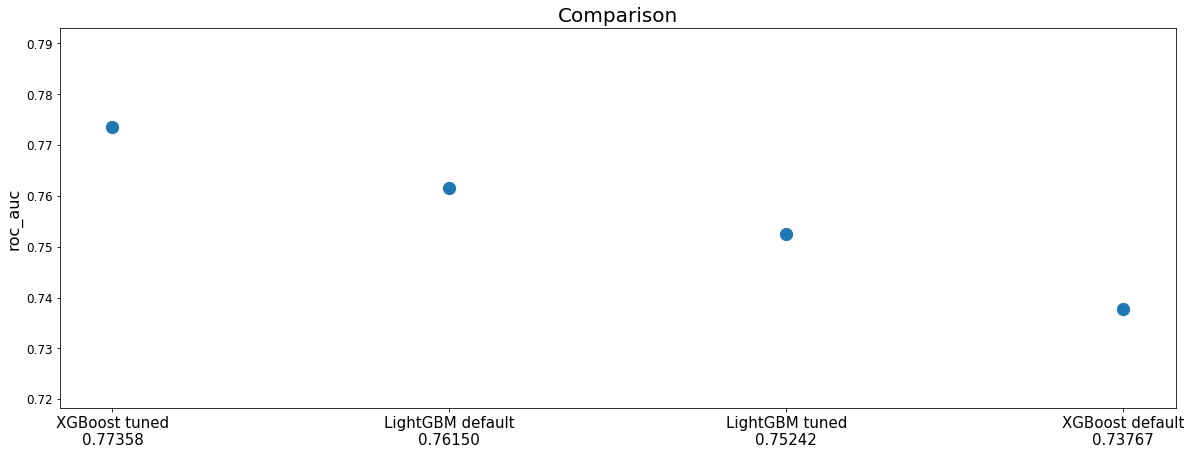

In [17]:
%pylab inline --no-import-all
metric, is_min_better = 'roc_auc', False
plot_metric_results(full_results, CANDIDATES.keys(), metric, is_min_better=is_min_better)